# Cognitive Portrait

Hello! Let's create some **Science Art** together with this **Cogntivie Portrait** challenge!

The goal of the challenge would be to use **[Face API](https://docs.microsoft.com/azure/cognitive-services/face/overview/?wt.mc_id=aiapril-github-dmitryso)** to create artistic pictures in the genere of **Generative Science Art**. This tutorial would show you how to create pictures like this:

<img src="https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/PhoBoGuy.png" width="40%"/>

The main idea is that Face API allows us to extract coordinates of key points of the face - so called **Facial Landmarks**. We will then use OpenCV machinery to apply some transformations to the image according to those key points. In the example above we have aligned all images according to their eyes, and then blended all images together -- a technique I call **[Cognitive People Blending](http://aka.ms/peopleblending)**. We can blend together pictures of one person, or of two or more different people. Experiment with different pictures to produce interesting results.

However, there are many other possible options on what you can do knowing eye coordinates -- for example, you can place all eyes on one circle, or on a sine wave, or create a multitude of faces fading away into horizon -- all that is limited by your creativity and your knowledge of image manipulation techniques. You can find some more examples in other notebooks in this repository. 

The original technique of using eye coordinates extracted by Cognitive Services was proposed by [Dmitry Soshnikov](http://soshnikov.com) and called **[Cognitive Portrait](http://aka.ms/cognitiveportrait)**.

### Some pre-requisites

We are going to do some image manipulations here, so we need OpenCV. It might not be included into our Python distribution, so to be on the safe side we will `pip`-install it. In addition, we would need `matplotlib` to show our results.

In [32]:
import sys
!{sys.executable} -m pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import glob, os

### Extracting Facial Landmarks

To extract facial landmarks, we will use [Microsoft Face API](https://azure.microsoft.com/services/cognitive-services/face/?wt.mc_id=crpyface-github-dmitryso). It provides a simple REST API that can extract a lot of useful information from the face image, including those landmarks:

![Facial Landmarks](https://raw.githubusercontent.com/shwars/FaceArt/master/notebooks/img/landmarks.jpg)

It is quite easy to call Face API directly via REST, but it is even better to use existing SDK, which is available for Python as part of [Azure SDK library](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/quickstarts/python-sdk/?wt.mc_id=crpyface-github-dmitryso).

You can [visit Microsoft Docs](https://docs.microsoft.com/ru-ru/azure/cognitive-services/face/index/?wt.mc_id=crpyface-github-dmitryso) for more detailed information on Face API and using it from languages other than Python.

In [33]:
!{sys.executable} -m pip install --quiet azure-cognitiveservices-vision-face

To use Face API, we need to provide a key and endpoint URL (because it is available in different regions, URL can be different). There are many ways to obtain Face API Key:

* If you have an Azure Subscription, the best option is to [create Cognitive Services resource](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account/?wt.mc_id=crpyface-github-dmitryso), and grab key/url from there
* You can always [create free trial subscription](https://azure.microsoft.com/free/?wt.mc_id=crpyface-github-dmitryso) (you would need a credit card for that)
* If you do not have an Azure Subscription, you can try Face API for free - request your trial key [here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=crpyface-github-dmitryso).

**Important:** If you use trial key, your Face API will have some limitations, in terms of number of images you can process, and frequency of API calls (not more than 20 calls per minute). In order to make things work, we would need to insert some pauses in between calls, when using API on a series of images.

After you get the key and endpoint, please insert them into the cell below. There would typically be two keys given on the portal, you can use any one of them.

In [35]:
key = '--INSERT YOUR KEY HERE--'
endpoint = 'https://westus2.api.cognitive.microsoft.com' 
# You might need different endpoint, check the cognitive services page!

Most of the calls of the Face API are done through the static module `cognitive_face`, which we will call `cf` for brevity.

In [36]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

The main function for face detection is called `face.detect_with_url` or `face.detect_with_stream`. It can extract a lot of useful information from the face, depending on the parameters that you specify - in our case we would need facial landmarks:

In [39]:
face_url = 'https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg'
res = cli.face.detect_with_url(face_url,return_face_landmarks=True)
print(res[0])

{'additional_properties': {}, 'face_id': '6dd0fd8f-9b0f-4adf-a1c6-7229ed09ee4b', 'recognition_model': None, 'face_rectangle': <azure.cognitiveservices.vision.face.models._models_py3.FaceRectangle object at 0x0000020D9A5A0608>, 'face_landmarks': <azure.cognitiveservices.vision.face.models._models_py3.FaceLandmarks object at 0x0000020D9A5A0648>, 'face_attributes': None}


## Getting Some Images

In this repository, sample images of Bill Gates are available in  `images/gates` directory. You can upload your own images using Azure Notebooks file upload feature. I suggest you create some other directory inside `images` for that purpose. Specify the directory name in the variable below:

In [40]:
path = 'images/gates/*'

Let's see how facial landmarks extraction works in practice by plotting points over a face:

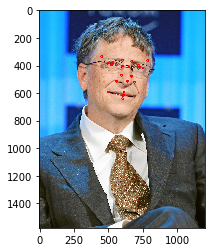

In [41]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fnames = glob.glob(path)

img = imread(fnames[0])
cli.face.detect_with_url(face_url)
with open(fnames[0],'rb') as f:
    res = cli.face.detect_with_stream(f,return_face_landmarks=True)
for k,v in res[0].face_landmarks.as_dict().items():
    cv2.circle(img,(int(v['x']),int(v['y'])),7,(255,0,0),5)
plt.imshow(img)

For our further experiments, let's load 13 first images, and run them through Face API to obtain facial landmarks. We will save the images into `images` array, and landmarks data into `imagepoints`.

In [42]:
filenames = []
images = []
imagepoints = []
cli.face.detect_with_url(face_url)
for fn in fnames[0:13]:
    print("Processing {}".format(fn))
    with open(fn,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=True)
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())

Processing images/gates\gates_0.jpg
Processing images/gates\gates_1.jpg
Processing images/gates\gates_10.jpg
Processing images/gates\gates_11.jpg
Processing images/gates\gates_12.jpg
Processing images/gates\gates_13.jpg
Processing images/gates\gates_14.jpg
Processing images/gates\gates_15.jpg
Processing images/gates\gates_16.jpg
Processing images/gates\gates_17.jpg
Processing images/gates\gates_19.jpg
Processing images/gates\gates_2.jpg
Processing images/gates\gates_21.jpg


In [43]:
print(imagepoints[0])

{'pupil_left': {'x': 530.2, 'y': 387.6}, 'pupil_right': {'x': 725.6, 'y': 410.9}, 'nose_tip': {'x': 637.9, 'y': 514.3}, 'mouth_left': {'x': 504.7, 'y': 593.0}, 'mouth_right': {'x': 689.4, 'y': 623.4}, 'eyebrow_left_outer': {'x': 454.0, 'y': 337.5}, 'eyebrow_left_inner': {'x': 604.4, 'y': 362.7}, 'eye_left_outer': {'x': 497.2, 'y': 385.8}, 'eye_left_top': {'x': 529.8, 'y': 381.0}, 'eye_left_bottom': {'x': 524.9, 'y': 397.7}, 'eye_left_inner': {'x': 558.2, 'y': 395.7}, 'eyebrow_right_inner': {'x': 670.2, 'y': 371.2}, 'eyebrow_right_outer': {'x': 785.7, 'y': 365.1}, 'eye_right_inner': {'x': 688.6, 'y': 410.4}, 'eye_right_top': {'x': 720.5, 'y': 403.0}, 'eye_right_bottom': {'x': 718.5, 'y': 421.4}, 'eye_right_outer': {'x': 750.4, 'y': 419.5}, 'nose_root_left': {'x': 601.6, 'y': 405.1}, 'nose_root_right': {'x': 650.6, 'y': 411.2}, 'nose_left_alar_top': {'x': 596.2, 'y': 473.7}, 'nose_right_alar_top': {'x': 666.6, 'y': 478.8}, 'nose_left_alar_out_tip': {'x': 558.2, 'y': 514.0}, 'nose_right_a

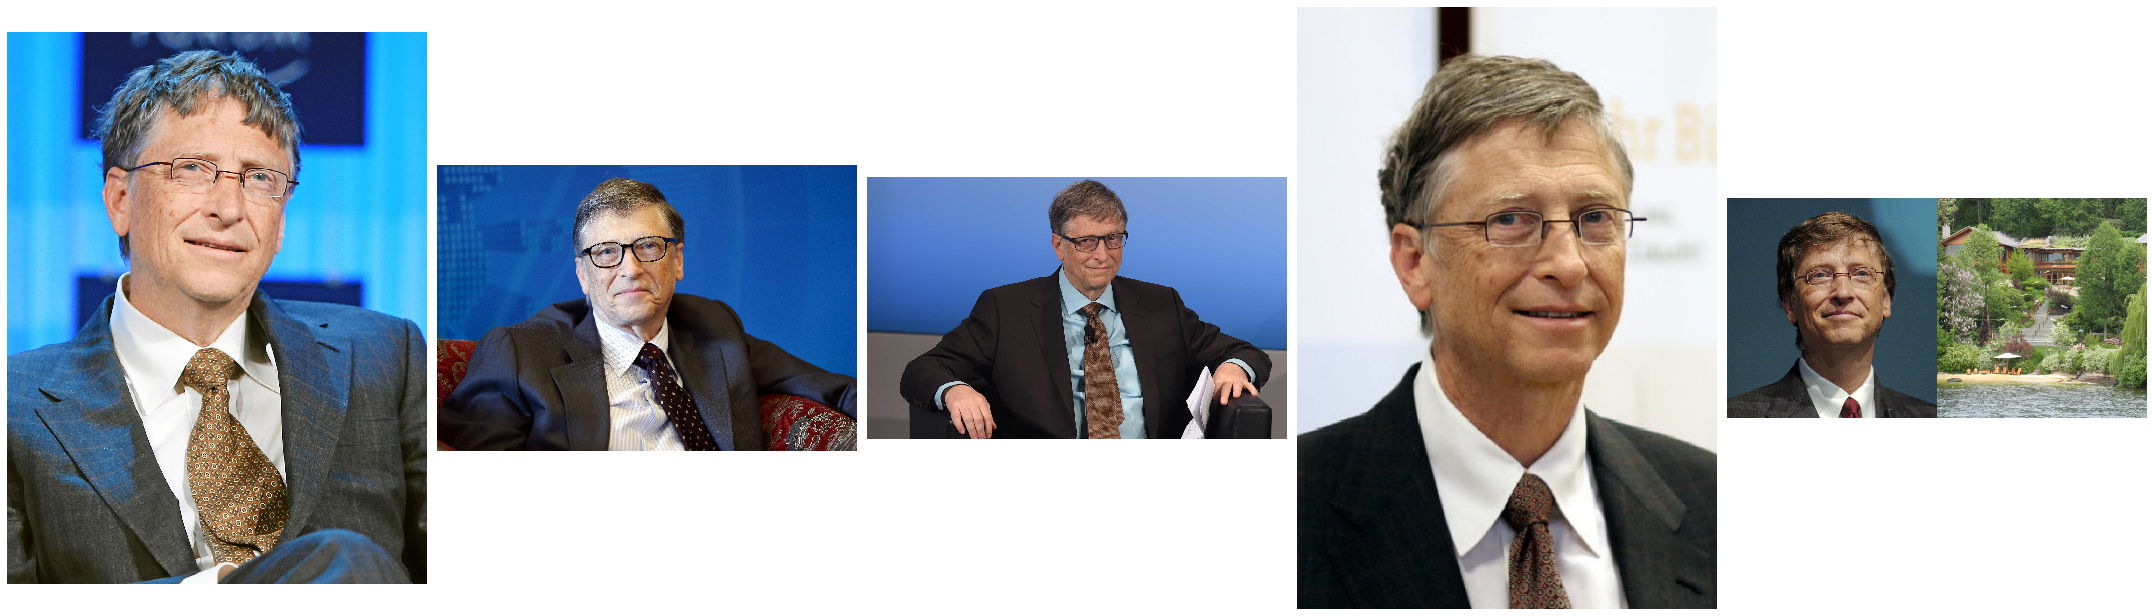

In [44]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images(images[:5])

## Affine Transformations

To get images all aligned, we need to position and rescale them according to the positions of eyes. To do that, we will use so-called [**affine transformation**](https://en.wikipedia.org/wiki/Affine_transformation). It includes many common image operations, such as scaling, rotation, skew, etc.

Such transformation can be defined in 2D-space using a matrix, and if we want to compute coordinates of a point after the transformation, we need to multiply them by this matrix. More precisely,
$$
\left(\begin{matrix}x'\cr y'\cr 1\end{matrix}\right) = M\times\left(\begin{matrix}x\cr y\cr 1\end{matrix}\right)
$$

In our case, we want to generate well-aligned portraits with eyes located at exactly the same position. Suppose the target image size is $300\times300$, then we can position eyes at points $(130,120)$ and $(170,120)$. 

It is known that affine transformation in 2D space can be uniquely defined by 3 points, i.e. we need to specify target coordinates for 3 given points in the image. In our case two such points will be left and right eye, and we need to chose the third point. A good choice would be to use some central point in the mouth, for example an average point between `mouth_left` and `mouth_right`.

In OpenCV, an affine transformation that maps given 3 points to another set of 3 points can be computed using `getAffineTransform` function. The resulting transformation can be applied to the whole image using `warpAffine` (and it also cuts out the remaining portions of the image, so that it fits the rectangle of the given size). 

Thus, the function to rotate our images to the fixes eyes-mouth position can be defined as follows:

In [45]:
import numpy as np

target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,attrs):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target_triangle)                                
    return cv2.warpAffine(img,tr,(size,size))

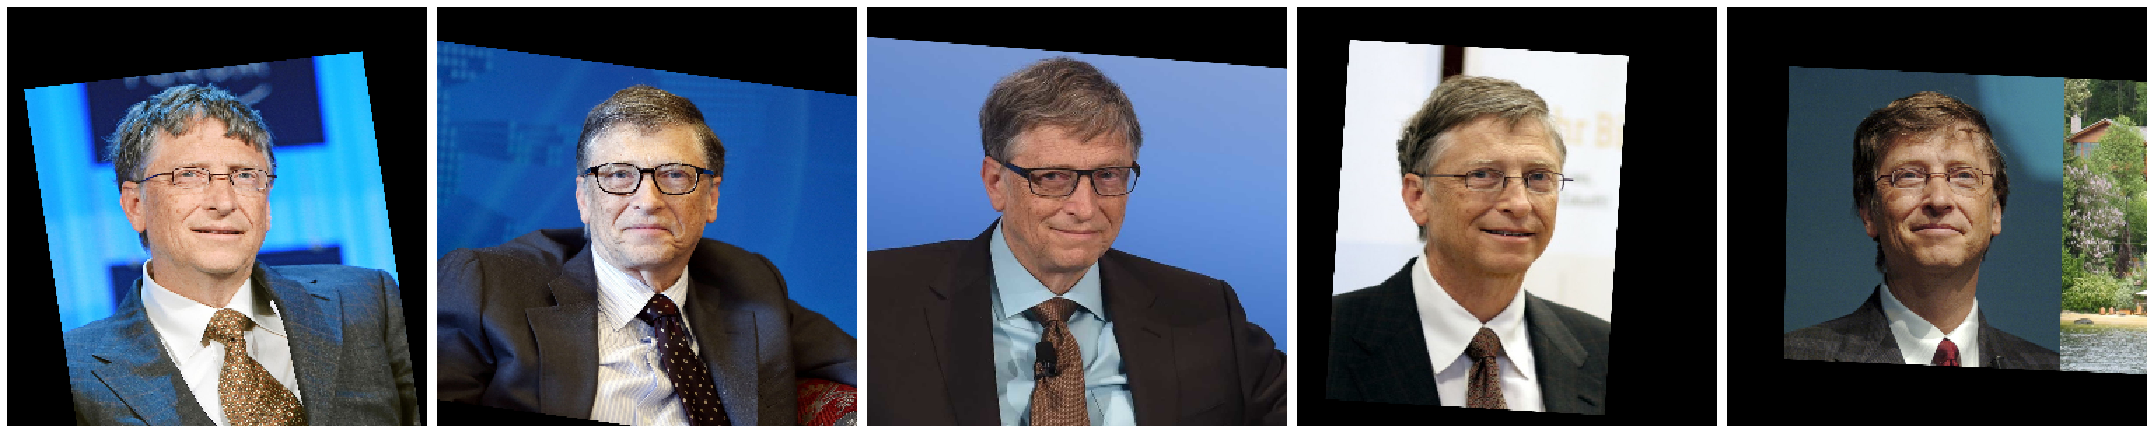

In [46]:
img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]
display_images(img_aligned[:5])

## Image Blending

Now we need to blend those images together to produce a nice result. Since images are represented in Python as `numpy` 3D-arrays, it is a simple operation of computing weighted average of those arrays. So, for two images $A$ and $B$, blended image can be computed as $C_{i,j,c} = \frac{1}{2}(A_{i,j,c}+B_{i,j,c})$ (here we denote by $c$ a color channel, so that $c\in\{1,2,3\}$).

In more general case, if $I^{(1)}, I^{(2)}, \dots, I^{(n)}$ are the images, and we want to blend them with different weights $\alpha_1, \alpha_2, \dots, \alpha_n$, such that $\alpha_1+\alpha_2+\dots+\alpha_n=1$, then the resulting merged image is computed as 
$$
M_{i,j,c} = \sum_{k=1}^n\alpha_k I^{(k)}_{i,j,c}
$$
or, in the matrix form,
$$
M = \sum_{k=1}^n\alpha_k I^{(k)} = \alpha_1 I^{(k)} + \dots + \alpha_n I^{(n)}
$$


In [47]:
def merge(images,wts=None):
    res = np.zeros_like(images[0],dtype=np.float32)
    if wts is None:
        wts = np.ones(len(images))
    wts /= np.sum(wts)
    for n,i in enumerate(images):
        res += wts[n]*i.astype(np.float32)
    return res.astype(np.ubyte)

In this function, if we do not specify weights vector - it is automatically assumed to be uniform.

Let's see how this function works for mixing two images:

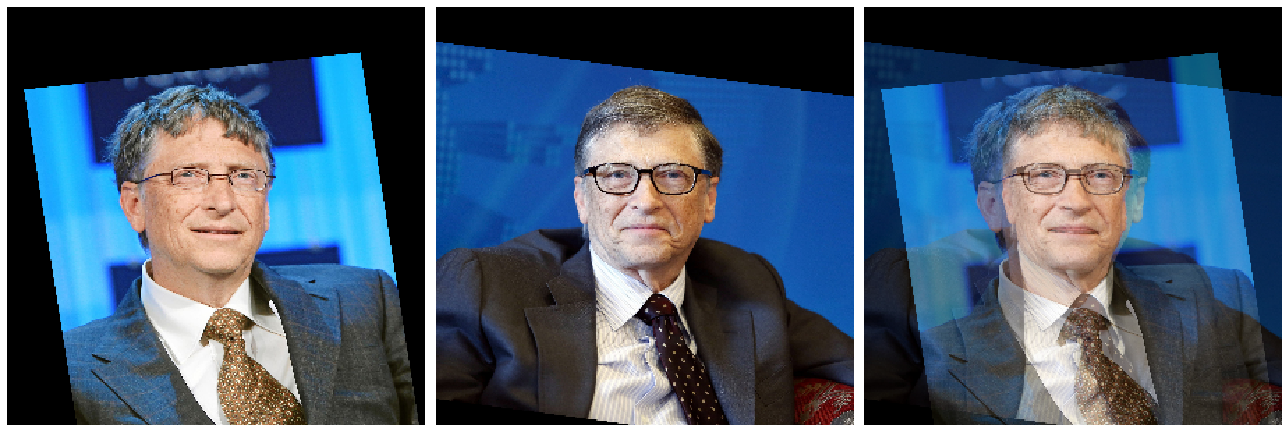

In [48]:
display_images([img_aligned[0],img_aligned[1],merge(img_aligned[0:2])])

Now let's merge all aligned images altogether and see what happens:

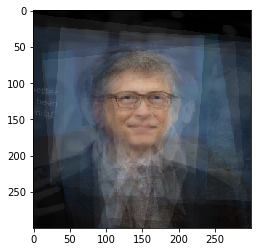

In [49]:
res = merge(img_aligned)
plt.imshow(res)

If this image does not look good, we can vary weights of different images, producing different results:

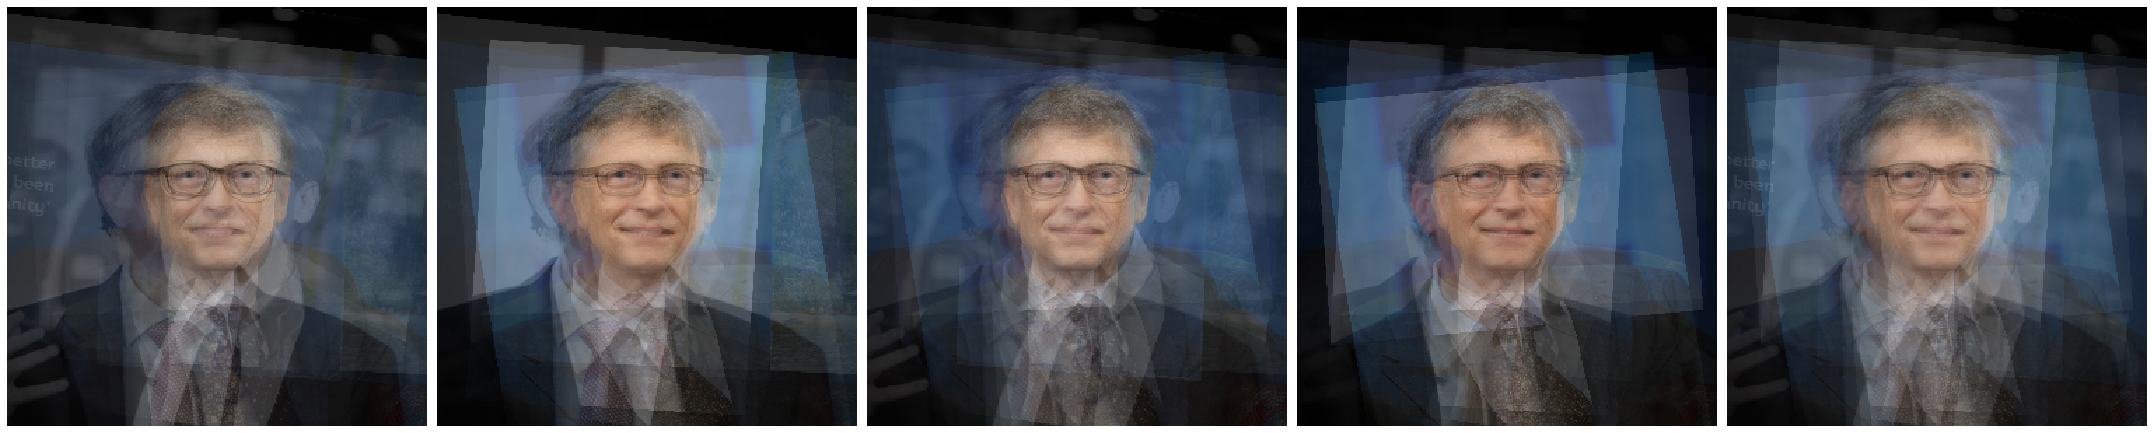

In [50]:
imgs = [merge(img_aligned,np.random.random(len(img_aligned))) for _ in range(5)]
display_images(imgs)

## Saving the result

I recommend to save the result into `results` directory, and to add quick description of the technique you used into `readme.md` file in the repo. To save the image, please execute the cell below:

In [31]:
cv2.imwrite('results/gates.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True